In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter, generic_filter
from astropy.io import fits
import matplotlib.pyplot as plt

In [3]:
# Function to count and locate bad pixels
def count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size):
    local_mean = gaussian_filter(image_data, sigma=neighborhood_size)
    local_std = np.sqrt(gaussian_filter((image_data - local_mean)**2, sigma=neighborhood_size))
    threshold = local_mean + threshold_factor * local_std
    bad_pixel_mask = image_data > threshold
    bad_pixel_coords = np.argwhere(bad_pixel_mask)
    num_bad_pixels = len(bad_pixel_coords)
    return num_bad_pixels, bad_pixel_coords, bad_pixel_mask

# Calculate spatial noise using a window method
def calculate_spatial_noise_window(image_data, window_size):
    spatial_noise = generic_filter(image_data, np.std, size=window_size)
    return spatial_noise

# Calculate temporal noise
def calculate_temporal_noise(image_stack):
    temporal_noise = np.std(image_stack, axis=0)
    return temporal_noise

def process_image(fits_filename, threshold_factor, neighborhood_size, window_size):
    hdul = fits.open(fits_filename)
    image_data = hdul[0].data
    hdul.close()
    num_bad_pixels, bad_pixel_coords, bad_pixel_mask = count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size)
    spatial_noise = calculate_spatial_noise_window(image_data, window_size)
    return image_data, bad_pixel_mask, spatial_noise

def process_images(fits_filenames, threshold_factor, neighborhood_size, window_size):
    image_stack = []
    spatial_noise_stack = []  # To store spatial noise of each image
    bad_pixel_mask_stack = []
    
    for fits_filename in fits_filenames:
        image_data, bad_pixel_mask, spatial_noise = process_image(fits_filename, threshold_factor, neighborhood_size, window_size)
        image_stack.append(image_data)
        spatial_noise_stack.append(spatial_noise)
        bad_pixel_mask_stack.append(bad_pixel_mask)

    # Combine into numpy arrays for further processing
    image_stack = np.array(image_stack)
    spatial_noise_stack = np.array(spatial_noise_stack)
    bad_pixel_mask_stack = np.array(bad_pixel_mask_stack)
    
    # Calculate temporal noise
    temporal_noise = calculate_temporal_noise(image_stack)
    
    # Analyze channels
    channels = 32
    columns_per_channel = 64
    best_channel = None
    best_channel_score = float('inf')
    channel_scores = []
    
    for channel in range(channels):
        start_col = channel * columns_per_channel
        end_col = start_col + columns_per_channel
        
        # Combine bad pixel masks across all frames for the current channel
        combined_bad_pixel_mask = np.any(bad_pixel_mask_stack[:, :, start_col:end_col], axis=0)
        
        channel_bad_pixels = np.sum(combined_bad_pixel_mask)
        channel_spatial_noise = np.mean(spatial_noise_stack[:, :, start_col:end_col])
        channel_temporal_noise = np.mean(temporal_noise[start_col:end_col])
        
        # Calculate channel score
        channel_score = channel_bad_pixels + channel_spatial_noise + channel_temporal_noise
        channel_scores.append(channel_score)
        
        if channel_score < best_channel_score:
            best_channel_score = channel_score
            best_channel = channel

    print(f"Best channel: {best_channel}")
    print(f"Score: {best_channel_score}")
    
    return best_channel, best_channel_score, channel_scores, image_stack, spatial_noise_stack, temporal_noise, bad_pixel_mask_stack

# Best region within the best channel
def find_best_region_in_channel(image_data, bad_pixel_mask, spatial_noise, temporal_noise, best_channel, region_height=159, region_width=36):
    rows, cols = image_data.shape[:2]
    columns_per_channel = 64  # Fixed number of columns per channel
    start_col = best_channel * columns_per_channel
    end_col = start_col + columns_per_channel

    # Adjust width if it exceeds the channel width (64)
    if region_width > columns_per_channel:
        print(f"Warning: Region width {region_width} exceeds channel width {columns_per_channel}. Adjusting to {columns_per_channel}.")
        region_width = columns_per_channel

    min_bad_pixels = float('inf')
    min_combined_noise = float('inf')
    best_region_start_row = 0
    best_region_start_col = 0
    
    # Search within the best channel columns
    for row in range(rows - region_height + 1):
        for col in range(start_col, end_col - region_width + 1):  # Limit search within the channel's 64 columns
            region_bad_pixels = np.sum(bad_pixel_mask[row:row+region_height, col:col+region_width])
            region_spatial_noise = np.mean(spatial_noise[row:row+region_height, col:col+region_width])
            region_temporal_noise = np.mean(temporal_noise[row:row+region_height, col:col+region_width])
            combined_noise = region_spatial_noise + region_temporal_noise
            
            if (region_bad_pixels < min_bad_pixels) or (region_bad_pixels == min_bad_pixels and combined_noise < min_combined_noise):
                min_bad_pixels = region_bad_pixels
                min_combined_noise = combined_noise
                best_region_start_row = row
                best_region_start_col = col
    
    return best_region_start_row, best_region_start_col

def visualize_best_region_on_full_frame(image_data, best_region_start_row, best_region_start_col, region_height=159, region_width=36):
    plt.figure(figsize=(10, 8))
    plt.imshow(image_data, cmap='gray', origin='lower')

    # Draw a rectangle showing the best region
    rect = plt.Rectangle((best_region_start_col, best_region_start_row), region_width, region_height,
                         edgecolor='red', facecolor='none', linewidth=2, label='Best Region')
    plt.gca().add_patch(rect)
    
    plt.title('Best Region on Full Detector Frame')
    plt.xlabel('X Pixels')
    plt.ylabel('Y Pixels')
    plt.legend()
    plt.show()

# Plot histogram of channel scores
def plot_channel_scores(channel_scores, best_channel):
    plt.figure(figsize=(10, 6))
    plt.bar(range(32), channel_scores)
    plt.xlabel('Channel')
    plt.ylabel('Score')
    plt.title('Channel Scores')
    plt.axvline(best_channel, color='r', linestyle='--', label=f'Best Channel: {best_channel}')
    plt.legend()
    plt.show()
    
def visualize_zoomed_region(image_data, best_region_start_row, best_region_start_col, region_height=159, region_width=36):
    # Extract the region of interest (ROI) from the image
    roi = image_data[best_region_start_row:best_region_start_row+region_height,
                     best_region_start_col:best_region_start_col+region_width]
    
    plt.figure(figsize=(6, 4))
    plt.imshow(roi, cmap='gray', origin='lower')
    plt.title('Zoomed-in View of Selected Region')
    plt.xlabel('X Pixels (relative)')
    plt.ylabel('Y Pixels (relative)')
    plt.colorbar(label='Pixel Values')
    plt.show()

In [4]:
fits_filenames = [f'12r_5c_1g_1res_1read/H2RG_Slow_FullWin_20241126_{str(i).zfill(6)}.fits' 
                  for i in range(1, 12)]
threshold_factor = 6
neighborhood_size = 5
window_size = 10  

best_channel, best_channel_score, channel_scores, image_stack, spatial_noise_stack, temporal_noise, bad_pixel_mask_stack = process_images(
    fits_filenames, threshold_factor, neighborhood_size, window_size)

Best channel: 5
Score: 386.4988670349121


In [5]:
# Find the best region within the best channel
best_region_start_row, best_region_start_col = find_best_region_in_channel(
    image_stack[0], 
    bad_pixel_mask_stack[0],  # Use bad_pixel_mask for the first image
    spatial_noise_stack[0], 
    temporal_noise, 
    best_channel,  # Pass the best channel
    region_height=159, 
    region_width=36
)


# Ensure you're looking at the best channel
channel_start_col = best_channel * 64  # Start of the best channel
channel_end_col = channel_start_col + 64  # End of the best channel

# Check if the best_region_start_col lies within the channel bounds
if not (channel_start_col <= best_region_start_col < channel_end_col):
    print(f"Error: Best region column ({best_region_start_col}) is not in the best channel ({best_channel}) range!")

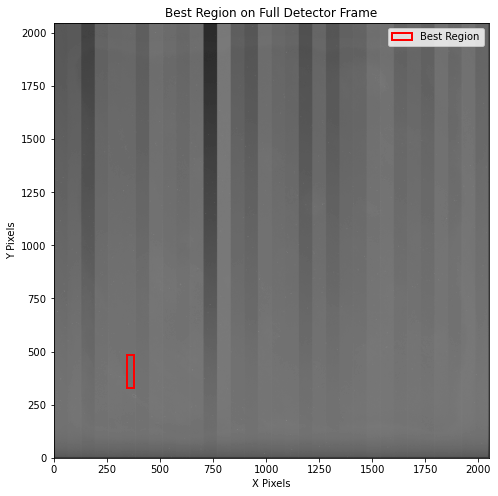

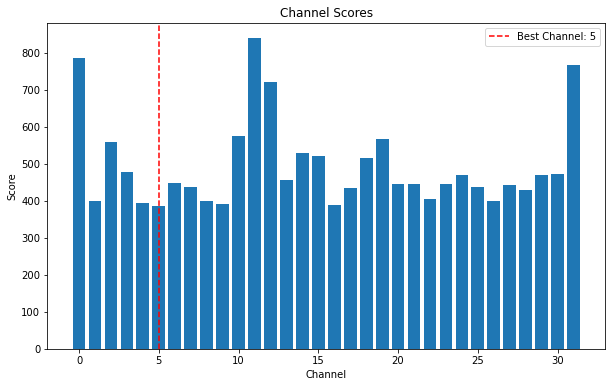

In [6]:
# Visualize the best region within the frame
visualize_best_region_on_full_frame(image_stack[0], best_region_start_row, best_region_start_col, region_height=159, region_width=36)

# Plot channel scores
plot_channel_scores(channel_scores, best_channel)

In [7]:
print(f"Best region coordinates: Start Row = {best_region_start_row}, Start Column = {best_region_start_col}")

Best region coordinates: Start Row = 326, Start Column = 343


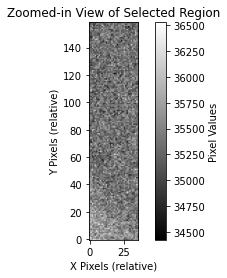

In [8]:
# After calling visualize_best_region_on_full_frame, call the zoomed region function:
visualize_zoomed_region(image_stack[0], best_region_start_row, best_region_start_col, region_height=159, region_width=36)

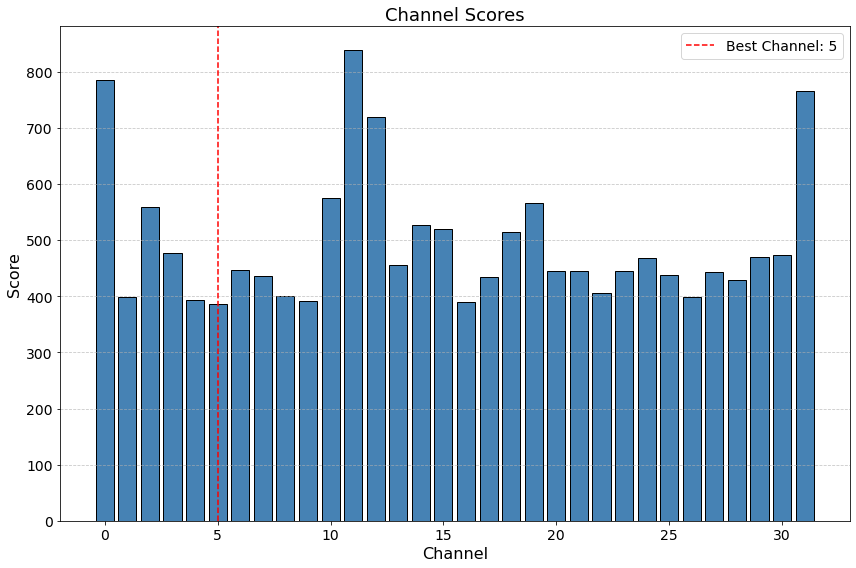

In [12]:
plt.figure(figsize=(12, 8))
plt.bar(range(32), channel_scores, color='steelblue', edgecolor='black')  # Use 'steelblue' for the bars
plt.xlabel('Channel', fontsize=16)  # Increase font size for x-axis label
plt.ylabel('Score', fontsize=16)    # Increase font size for y-axis label
plt.title('Channel Scores', fontsize=18)  # Increase font size for the title
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase font size for tick labels
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add light gridlines for better readability
plt.axvline(best_channel, color='r', linestyle='--', label=f'Best Channel: {best_channel}',fontsize=16)
plt.legend(fontsize=14)  # Adjust font size for legend if uncommented
plt.tight_layout()
plt.savefig('channel_score.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
def visualize_best_region_on_full_frame(image_data, best_region_start_row, best_region_start_col, region_height=159, region_width=36):
    plt.figure(figsize=(12, 8))
    plt.imshow(image_data, cmap='gray', origin='lower')

    # Draw a rectangle showing the best region
    rect = plt.Rectangle((best_region_start_col, best_region_start_row), region_width, region_height,
                         edgecolor='red', facecolor='none', linewidth=2, label='Best Region')
    plt.gca().add_patch(rect)
    
    plt.title('Best Vertical Region on Full Detector Frame', fontsize=18)
    plt.xlabel('X Pixels', fontsize=16)
    plt.ylabel('Y Pixels', fontsize=16)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig('full_frame_R400.png', dpi=300, bbox_inches='tight')
    plt.show()
    
def visualize_zoomed_region(image_data, best_region_start_row, best_region_start_col, region_height=159, region_width=36):
    # Extract the region of interest (ROI) from the image
    roi = image_data[best_region_start_row:best_region_start_row+region_height,
                     best_region_start_col:best_region_start_col+region_width]
    
    plt.figure(figsize=(6, 4))
    plt.imshow(roi, cmap='gray', origin='lower')
#     plt.title('Zoomed-in View of Selected Region')
#     plt.xlabel('X Pixels (relative)')
#     plt.ylabel('Y Pixels (relative)')
#     plt.colorbar(label='Pixel Values')
    plt.savefig('zoomin_R400.png', dpi=300, bbox_inches='tight')
    plt.show()

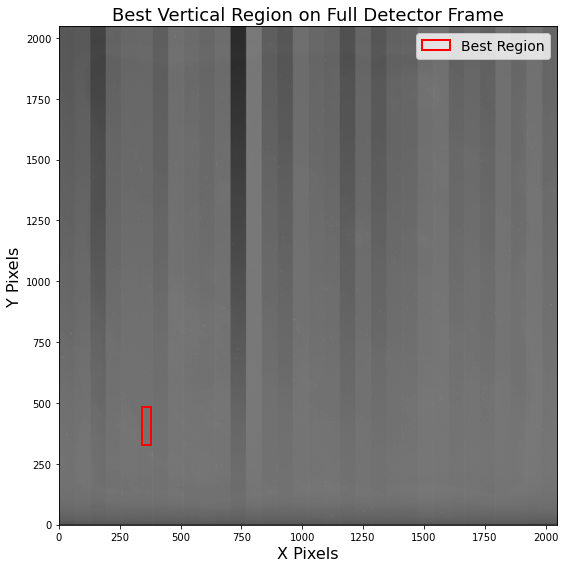

In [13]:
visualize_best_region_on_full_frame(image_stack[0], best_region_start_row, best_region_start_col, region_height=159, region_width=36)

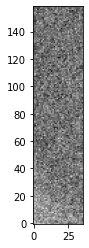

In [11]:
# After calling visualize_best_region_on_full_frame, call the zoomed region function:
visualize_zoomed_region(image_stack[0], best_region_start_row, best_region_start_col, region_height=159, region_width=36)